In [60]:
import numpy
import pandas
import matplotlib.pyplot
import statsmodels.api
import statsmodels.tsa.stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from numpy.polynomial.polynomial import Polynomial
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [61]:
import warnings
warnings.filterwarnings('ignore')

In [62]:
data_prices = pandas.read_csv("./data/data_zillow_house_prices.csv")
data_rates = pandas.read_csv("./data/data_interest_rates.csv")

In [63]:
data_prices

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31
0,102001,0,United States,country,NaN,127881.0,128227.0,128591.0,129332.0,130079.0,...,318303.0,322658.0,327381.0,332588.0,337848.0,343392.0,348415.0,352585.0,354986.0,356026.0
1,394913,1,"New York, NY",msa,NY,224676.0,226018.0,227226.0,229604.0,231817.0,...,573600.0,576842.0,580804.0,585445.0,591876.0,599008.0,606525.0,612535.0,616856.0,619142.0
2,753899,2,"Los Angeles, CA",msa,CA,227786.0,228579.0,229794.0,232104.0,234580.0,...,845860.0,855023.0,865646.0,877802.0,895038.0,914016.0,930381.0,931707.0,928599.0,914636.0
3,394463,3,"Chicago, IL",msa,IL,170004.0,170405.0,170924.0,171963.0,173064.0,...,288807.0,291527.0,294162.0,296729.0,300023.0,303490.0,307454.0,310438.0,312286.0,312609.0
4,394514,4,"Dallas, TX",msa,TX,129921.0,130025.0,130112.0,130323.0,130544.0,...,337274.0,343129.0,350514.0,358982.0,367040.0,376487.0,385149.0,392668.0,394861.0,393920.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,753929,923,"Zapata, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,107811.0,110066.0,112647.0,115339.0,115955.0,116220.0,116214.0,117199.0,118364.0,119798.0
889,394743,924,"Ketchikan, AK",msa,AK,NaN,NaN,NaN,NaN,NaN,...,341382.0,346968.0,352628.0,357313.0,357544.0,358017.0,359810.0,363289.0,366462.0,369645.0
890,753874,925,"Craig, CO",msa,CO,94670.0,95014.0,95596.0,96288.0,97002.0,...,244237.0,247636.0,250594.0,252962.0,253211.0,253361.0,254294.0,258151.0,262571.0,267315.0
891,394767,926,"Lamesa, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,93043.0,94667.0,96323.0,98574.0,99773.0,100829.0,101918.0,103465.0,105142.0,106274.0


In [64]:
data_rates.set_index('DATE', inplace=True)
data_rates.index = pandas.to_datetime(data_rates.index)
data_rates

,MORTGAGE30US
DATE,
1971-04-02,7.33
1971-04-09,7.31
1971-04-16,7.31
1971-04-23,7.31
1971-04-30,7.29
...,...
2022-08-11,5.22
2022-08-18,5.13
2022-08-25,5.55


In [65]:
data_prices[data_prices['RegionName'] == 'Boston, MA']

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31
11,394404,11,"Boston, MA",msa,MA,231718.0,233010.0,234265.0,236467.0,238657.0,...,607781.0,612597.0,618039.0,625202.0,633597.0,643355.0,651279.0,656882.0,658173.0,657035.0


In [66]:
source_data = data_prices[data_prices['RegionName'] == 'Boston, MA'].drop(labels=['RegionID', 'SizeRank', 'RegionType', 'StateName'], axis = 1).set_index('RegionName').T
source_data.index = pandas.to_datetime(source_data.index)
source_data = source_data.asfreq('ME')

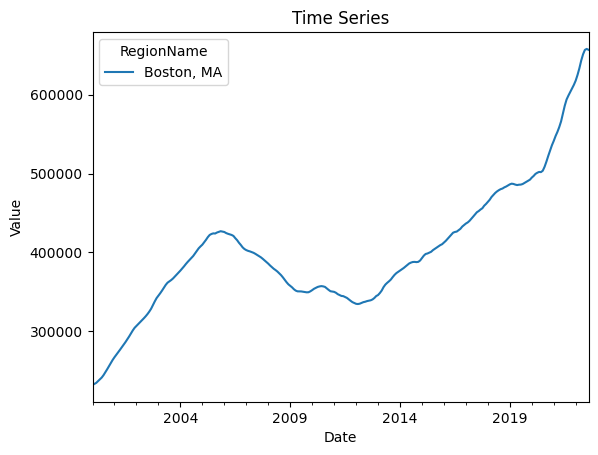

In [67]:
source_data.plot()
matplotlib.pyplot.title('Time Series')
matplotlib.pyplot.xlabel('Date')
matplotlib.pyplot.ylabel('Value')
matplotlib.pyplot.show()

In [68]:
data = source_data[(source_data.index <= '2017-12-31') & (source_data.index >= '2010-01-01')]
data

RegionName,"Boston, MA"
2010-01-31,352001.0
2010-02-28,353713.0
2010-03-31,354899.0
2010-04-30,356066.0
2010-05-31,356716.0
...,...
2017-08-31,452393.0
2017-09-30,454372.0
2017-10-31,455955.0
2017-11-30,459183.0


In [69]:
result = statsmodels.tsa.stattools.adfuller(data)
test_statistic = result[0]
p_value = result[1]

print("Dickey-Fuller Test Statistic:", test_statistic)
print("p-value:", p_value)
print("Critical Values:")
for key, value in result[4].items():
    print(f"{key}: {value}")

Dickey-Fuller Test Statistic: 0.3310333258733708
p-value: 0.9787243261392025
Critical Values:
1%: -3.50434289821397
5%: -2.8938659630479413
10%: -2.5840147047458037


In [70]:
def remove_terms(data, max_degree=3):
    data = numpy.array(data)
    for degree in range(1, max_degree+1):
        x = numpy.arange(len(data))
        p = Polynomial.fit(x, data, deg = degree)
        detrended_data = data - p(x)

        result = statsmodels.tsa.stattools.adfuller(detrended_data)
        p_value = result[1]
        
        print(f"Degree {degree} polynomial removed, p-value: {p_value}")
        
        if p_value < 0.05:
            return detrended_data, degree, p_value

In [71]:
detrended_data, degree_removed, final_p_value = remove_terms(numpy.array(data['Boston, MA']))
print(f"Final p-value: {final_p_value}, Degree removed: {degree_removed}")


Degree 1 polynomial removed, p-value: 0.032879060714282454
Final p-value: 0.032879060714282454, Degree removed: 1


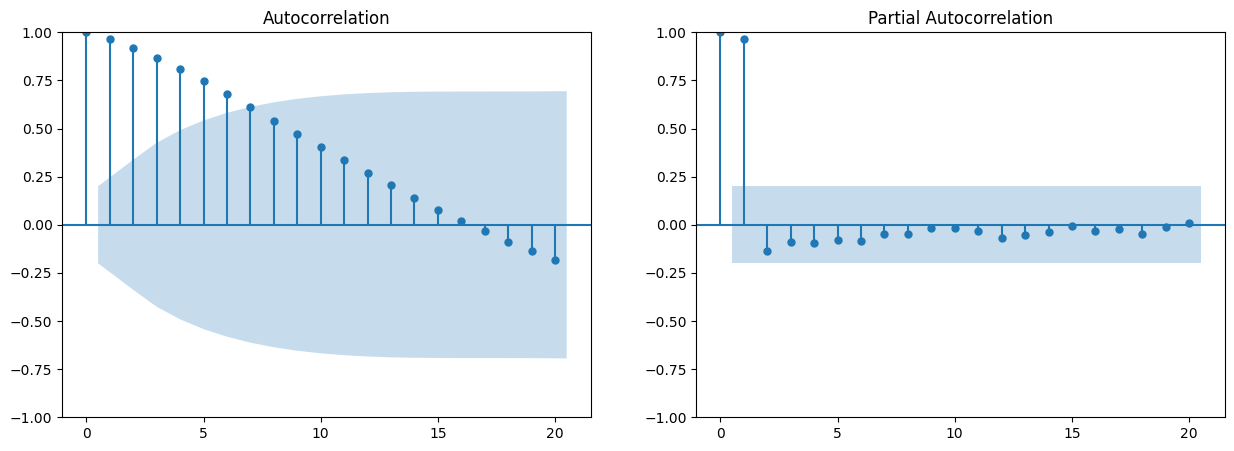

In [72]:
fig, axes = matplotlib.pyplot.subplots(1,2, figsize=(15,5))
plot_acf(detrended_data, lags = 20, ax = axes[0])
plot_pacf(detrended_data, lags = 20, ax = axes[1])
matplotlib.pyplot.show()

In [73]:
train = source_data[(source_data.index <= '2017-12-31') & (source_data.index >= '2010-01-01')]
test = source_data[(source_data.index <= '2019-12-31') & (source_data.index >= '2018-01-01')]

mse_values = []

for p in range(1, 6):
    model = AutoReg(train, lags=p).fit()
    predictions = model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
    mse = mean_squared_error(test, predictions)
    mse_values.append(mse)
    print(f'AR({p}) MSE: {mse}')

for p in range(1, 5):
    print(f'MSE fluctuations {p}-{p+1}: {mse_values[p-1]-mse_values[p]}')

AR(1) MSE: 702663399.9162525
AR(2) MSE: 276035762.2080894
AR(3) MSE: 277220375.27339727
AR(4) MSE: 378501994.4623239
AR(5) MSE: 114930066.00818305
MSE fluctuations 1-2: 426627637.7081631
MSE fluctuations 2-3: -1184613.0653078556
MSE fluctuations 3-4: -101281619.18892664
MSE fluctuations 4-5: 263571928.45414084


In [74]:
optimal_p = 2
model = ARIMA(train, order=(optimal_p, 0, 0), enforce_stationarity=False).fit()

predictions_long_term = model.predict(start='2018-01-01', end='2019-12-31')
mse_long_term = mean_squared_error(test['2018-05-01':'2018-05-31'], predictions_long_term['2018-05-01':'2018-05-31'])
print(f'Long-Term Prediction MSE for May 2018: {mse_long_term}')


Long-Term Prediction MSE for May 2018: 17404855.932860166


In [75]:
predictions_short_term = []
for i in range(len(test)):
    end_date = train.index[-1] + pandas.DateOffset(months=1)
    model = ARIMA(train, order=(optimal_p, 0, 0), enforce_stationarity=False).fit()
    pred = model.forecast(steps=1)
    predictions_short_term.append(pred.iloc[0])
    train = pandas.concat([train, test.iloc[i:i+1]])

predictions_short_term = pandas.Series(predictions_short_term, index=test.index)

mse_short_term = mean_squared_error(test['2018-05-01':'2018-05-31'], predictions_short_term['2018-05-01':'2018-05-31'])
print(f'Short-Term Prediction MSE for May 2018: {mse_short_term}')


Short-Term Prediction MSE for May 2018: 2748.7742089251856


In [76]:
short_mse = mean_squared_error(test, predictions_short_term)
long_mse = mean_squared_error(test, predictions_long_term)

print(f'Short-Term MSE: {short_mse}')
print(f'Long-Term MSE: {long_mse}')

Short-Term MSE: 303580.34893254744
Long-Term MSE: 17341666.718557034


In [77]:
def fit_arx_model(data, exog, p):
    model = ARIMA(data, order=(p, 0, 0), exog=exog)
    model_fit = model.fit()
    return model_fit

def fit_armax_model(data, exog, p, q):
    model = ARIMA(data, order=(p, 0, q), exog=exog)
    model_fit = model.fit()
    return model_fit

In [78]:
train = source_data[(source_data.index <= '2017-12-31') & (source_data.index >= '2010-01-01')]
test = source_data[(source_data.index <= '2019-12-31') & (source_data.index >= '2018-01-01')]

In [79]:
train

RegionName,"Boston, MA"
2010-01-31,352001.0
2010-02-28,353713.0
2010-03-31,354899.0
2010-04-30,356066.0
2010-05-31,356716.0
...,...
2017-08-31,452393.0
2017-09-30,454372.0
2017-10-31,455955.0
2017-11-30,459183.0


In [80]:
exogen_data = data_rates[(data_rates.index <= '2017-12-31') & (data_rates.index >= '2010-01-01')]
test_exogen_data = data_rates[(data_rates.index <= '2019-12-31') & (data_rates.index >= '2018-01-01')]
monthly_exogen_data = exogen_data.resample('M').median()
monthly_test_exogen_data = test_exogen_data.resample('M').median()

In [81]:
for p in range (1,6):
    arx_model = fit_arx_model(train['Boston, MA'], monthly_exogen_data['MORTGAGE30US'], p)
    predictions = arx_model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False, exog = monthly_test_exogen_data)
    mse = mean_squared_error(test, predictions)
    print(f'ARX({p}) MSE (Out-Sample): {mse}')
    
for p in range (1,6):
    arx_model = fit_arx_model(train['Boston, MA'], monthly_exogen_data['MORTGAGE30US'], p)
    predictions = arx_model.predict(start=0, end=len(train) - 1, dynamic=False, exog = monthly_exogen_data)
    mse = mean_squared_error(train, predictions)
    print(f'ARX({p}) MSE (In-Sample): {mse}')

ARX(1) MSE (Out-Sample): 468632892.2913925
ARX(2) MSE (Out-Sample): 97064414.3213756
ARX(3) MSE (Out-Sample): 150237613.01056644
ARX(4) MSE (Out-Sample): 1268000749.4376185
ARX(5) MSE (Out-Sample): 1279891183.8763463
ARX(1) MSE (In-Sample): 179156445.4049602
ARX(2) MSE (In-Sample): 191967418.78899765
ARX(3) MSE (In-Sample): 70639885.32799198
ARX(4) MSE (In-Sample): 12688513.312315425
ARX(5) MSE (In-Sample): 12677511.966020549


In [82]:
best_p = None
best_q = None
best_mse = float("inf")

for p in range (1,6):
    for q in [1, 5, 10]:
        armax_model = fit_armax_model(train['Boston, MA'], monthly_exogen_data['MORTGAGE30US'], p, q)
        predictions = armax_model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False, exog = monthly_test_exogen_data)
        mse = mean_squared_error(test, predictions)
        print(f'ARMAX({p}, {q}) MSE (Out-Sample): {mse}')
        if mse < best_mse:
            best_mse = mse
            best_p = p
            best_q = q

print(f'Best p: {best_p}, Best q: {best_q}, Best MSE: {best_mse}')

best_p = None
best_q = None
best_mse = float("inf")

for p in range (1,6):
    for q in [1, 5, 10]:
        armax_model = fit_armax_model(train['Boston, MA'], monthly_exogen_data['MORTGAGE30US'], p, q)
        predictions = armax_model.predict(start=0, end=len(train) - 1, dynamic=False, exog = monthly_exogen_data)
        mse = mean_squared_error(train, predictions)
        print(f'ARMAX({p}, {q}) MSE (In-Sample): {mse}')
        if mse < best_mse:
            best_mse = mse
            best_p = p
            best_q = q

print(f'Best p: {best_p}, Best q: {best_q}, Best MSE: {best_mse}')

ARMAX(1, 1) MSE (Out-Sample): 820516120.2845505
ARMAX(1, 5) MSE (Out-Sample): 1100255387.8959358
ARMAX(1, 10) MSE (Out-Sample): 1151513956.6163442
ARMAX(2, 1) MSE (Out-Sample): 1337317657.064188
ARMAX(2, 5) MSE (Out-Sample): 1051463046.3855238
ARMAX(2, 10) MSE (Out-Sample): 1504374538.9366138
ARMAX(3, 1) MSE (Out-Sample): 587066869.2061216
ARMAX(3, 5) MSE (Out-Sample): 1919873189.8509586
ARMAX(3, 10) MSE (Out-Sample): 1384827880.3138263
ARMAX(4, 1) MSE (Out-Sample): 1216509521.3256032
ARMAX(4, 5) MSE (Out-Sample): 2866234317.0036607
ARMAX(4, 10) MSE (Out-Sample): 1006871874.8547964
ARMAX(5, 1) MSE (Out-Sample): 1238726975.0104601
ARMAX(5, 5) MSE (Out-Sample): 944834810.8981977
ARMAX(5, 10) MSE (Out-Sample): 933099416.2802082
Best p: 3, Best q: 1, Best MSE: 587066869.2061216
ARMAX(1, 1) MSE (In-Sample): 17883628.199614815
ARMAX(1, 5) MSE (In-Sample): 12894775.329687005
ARMAX(1, 10) MSE (In-Sample): 12336680.978080167
ARMAX(2, 1) MSE (In-Sample): 12657465.25971651
ARMAX(2, 5) MSE (In-Sam

In [83]:
train = source_data[(source_data.index <= '2017-12-31') & (source_data.index >= '2010-01-01')]
test = source_data[(source_data.index <= '2019-12-31') & (source_data.index >= '2018-01-01')]

for p in range(1, 6):
    model = AutoReg(train, lags=p).fit()
    in_sample_predictions = model.predict(start=0, end=len(train) - 1, dynamic=False)
    in_sample_mse = mean_squared_error(train[p:], in_sample_predictions[p:])
    print(f'AR({p}) In-Sample MSE: {in_sample_mse}')

for p in range(1, 6):
    model = AutoReg(train, lags=p).fit()
    out_sample_predictions = model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
    out_sample_mse = mean_squared_error(test, out_sample_predictions)
    print(f'AR({p}) Out-Sample MSE: {out_sample_mse}')

train = source_data[(source_data.index <= '2019-12-31') & (source_data.index >= '2010-01-01')]
test = source_data[(source_data.index <= '2021-12-31') & (source_data.index >= '2020-01-01')]

for p in range(1, 6):
    model = AutoReg(train, lags=p).fit()
    in_sample_predictions = model.predict(start=0, end=len(train) - 1, dynamic=False)
    in_sample_mse = mean_squared_error(train[p:], in_sample_predictions[p:])
    print(f'AR({p}) In-Sample MSE: {in_sample_mse}')

for p in range(1, 6):
    model = AutoReg(train, lags=p).fit()
    out_sample_predictions = model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
    out_sample_mse = mean_squared_error(test, out_sample_predictions)
    print(f'AR({p}) Out-Sample MSE: {out_sample_mse}')

AR(1) In-Sample MSE: 1534552.8360407595
AR(2) In-Sample MSE: 454477.76734143094
AR(3) In-Sample MSE: 453230.41035351565
AR(4) In-Sample MSE: 450017.87885450554
AR(5) In-Sample MSE: 361793.74850441114
AR(1) Out-Sample MSE: 702663399.9162525
AR(2) Out-Sample MSE: 276035762.2080894
AR(3) Out-Sample MSE: 277220375.27339727
AR(4) Out-Sample MSE: 378501994.4623239
AR(5) Out-Sample MSE: 114930066.00818305
AR(1) In-Sample MSE: 1692335.2468675748
AR(2) In-Sample MSE: 423045.88411819143
AR(3) In-Sample MSE: 422748.007893716
AR(4) In-Sample MSE: 417252.2614404143
AR(5) In-Sample MSE: 348654.83469264174
AR(1) Out-Sample MSE: 1300260312.8791492
AR(2) Out-Sample MSE: 1835182528.7828643
AR(3) Out-Sample MSE: 1787087579.4398823
AR(4) Out-Sample MSE: 1657747139.2274323
AR(5) Out-Sample MSE: 2102967593.5284154


In [84]:
exogen_data = data_rates[(data_rates.index <= '2017-12-31') & (data_rates.index >= '2010-01-01')]
test_exogen_data = data_rates[(data_rates.index <= '2019-12-31') & (data_rates.index >= '2018-01-01')]
total_exogen_data =  data_rates[(data_rates.index <= '2019-12-31') & (data_rates.index >= '2010-01-01')]
monthly_exogen_data = exogen_data.resample('M').median()
monthly_test_exogen_data = test_exogen_data.resample('M').median()
monthly_total_exogen_data = total_exogen_data.resample('M').median()


train = source_data[(source_data.index <= '2017-12-31') & (source_data.index >= '2010-01-01')]
test = source_data[(source_data.index <= '2019-12-31') & (source_data.index >= '2018-01-01')]

for p in range(1, 6):
    model = AutoReg(train['Boston, MA'], lags=p, exog=monthly_exogen_data['MORTGAGE30US']).fit()
    in_sample_predictions = model.predict(start=0, end=len(train) - 1, dynamic=False, exog=monthly_exogen_data['MORTGAGE30US'])
    in_sample_mse = mean_squared_error(train['Boston, MA'][p:], in_sample_predictions[p:])
    print(f'ARX({p}) In-Sample MSE: {in_sample_mse}')

for p in range(1, 6):
    model = AutoReg(train['Boston, MA'], lags=p, exog=monthly_exogen_data['MORTGAGE30US']).fit()
    out_sample_predictions = model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False, exog=monthly_exogen_data['MORTGAGE30US'], exog_oos=monthly_test_exogen_data['MORTGAGE30US'])
    out_sample_mse = mean_squared_error(test['Boston, MA'], out_sample_predictions)
    print(f'ARX({p}) Out-Sample MSE: {out_sample_mse}')


exogen_data = data_rates[(data_rates.index <= '2019-12-31') & (data_rates.index >= '2010-01-01')]
test_exogen_data = data_rates[(data_rates.index <= '2021-12-31') & (data_rates.index >= '2020-01-01')]
monthly_exogen_data = exogen_data.resample('M').median()
monthly_test_exogen_data = test_exogen_data.resample('M').median()

train = source_data[(source_data.index <= '2019-12-31') & (source_data.index >= '2010-01-01')]
test = source_data[(source_data.index <= '2021-12-31') & (source_data.index >= '2020-01-01')]

for p in range(1, 6):
    model = AutoReg(train['Boston, MA'], lags=p, exog=monthly_exogen_data['MORTGAGE30US']).fit()
    in_sample_predictions = model.predict(start=0, end=len(train) - 1, dynamic=False, exog=monthly_exogen_data['MORTGAGE30US'])
    in_sample_mse = mean_squared_error(train['Boston, MA'][p:], in_sample_predictions[p:])
    print(f'ARX({p}) In-Sample MSE: {in_sample_mse}')

for p in range(1, 6):
    model = AutoReg(train['Boston, MA'], lags=p, exog=monthly_exogen_data['MORTGAGE30US']).fit()
    out_sample_predictions = model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False, exog=monthly_exogen_data['MORTGAGE30US'], exog_oos=monthly_test_exogen_data['MORTGAGE30US'])
    out_sample_mse = mean_squared_error(test['Boston, MA'], out_sample_predictions)
    print(f'ARX({p}) Out-Sample MSE: {out_sample_mse}')


ARX(1) In-Sample MSE: 1358662.6238075353
ARX(2) In-Sample MSE: 428363.07418692356
ARX(3) In-Sample MSE: 430068.5950908167
ARX(4) In-Sample MSE: 425448.62025658874
ARX(5) In-Sample MSE: 334789.5347973029
ARX(1) Out-Sample MSE: 275038242.3334239
ARX(2) Out-Sample MSE: 25774162.66119526
ARX(3) Out-Sample MSE: 32861976.86313803
ARX(4) Out-Sample MSE: 52437058.95026519
ARX(5) Out-Sample MSE: 50150692.32023901
ARX(1) In-Sample MSE: 1529652.9407863838
ARX(2) In-Sample MSE: 398763.7969277716
ARX(3) In-Sample MSE: 401259.38064594154
ARX(4) In-Sample MSE: 397124.60041722306
ARX(5) In-Sample MSE: 323500.0906160042
ARX(1) Out-Sample MSE: 491946913.2685732
ARX(2) Out-Sample MSE: 297241661.0544283
ARX(3) Out-Sample MSE: 310455195.770324
ARX(4) Out-Sample MSE: 280564807.0250118
ARX(5) Out-Sample MSE: 245878877.25341502
